In [10]:
# 可视化类激活的热力图
# 加载带有预训练权重的vgg16网络
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')



In [11]:
# 预处理一张输入图像
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
# 添加一个维度
x = np.expand_dims(x, axis=0)
# 对批量进行预处理

x = preprocess_input(x)



In [12]:
preds = model.predict(x)

print('predicted', decode_predictions(preds, top=3)[0])

predicted [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


In [13]:
np.argmax(preds[0])

386

In [14]:
# grad_cam算法
from keras import backend as k
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = k.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = k.mean(grads, axis=(0 ,1 ,2))

iterate = k.function([model.input]
            ,[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value , conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis = -1)

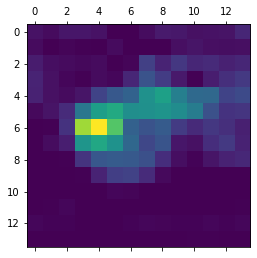

In [15]:
# 热力图后处理
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

In [16]:
# 将热力图与原始图像叠加
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True